In [1]:
# configure spark variables
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

# load up other dependencies
import re
import pandas as pd

import glob
import matplotlib.pyplot as plt
import numpy as np

22/02/08 23:05:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql.functions import *
from pyspark.sql.functions import split, explode

In [3]:
def plot_netcount_results(file, title):
    bpftrace_netcount_pattern = r'^@(\w+)\[(.+)\]\D*(\d+)'
    stl_dns_streams_netcount_file = glob.glob(file)
    stl_dns_streams_netcount_df = spark.read.text(stl_dns_streams_netcount_file)

    bpftrace_cs_df = stl_dns_streams_netcount_df.select(
                                regexp_extract('value', bpftrace_netcount_pattern, 1).alias('action'),
                                regexp_extract('value', bpftrace_netcount_pattern, 2).alias('device'), 
                                regexp_extract('value', bpftrace_netcount_pattern, 3).cast('integer').alias('packets'),                               
                    ).filter(' action != ""').withColumn("order", monotonically_increasing_id())
    
    uniq_names = ['nic_recv_count', 'nic_send_count']
    tables = [bpftrace_cs_df.where(bpftrace_cs_df.action == x) for x in uniq_names]

    list_tables = []
    uniq_devices = ['enP39834s2', 'enP45535s3', 'eth1', 'eth2']
    fig, axs = plt.subplots(1, 2, figsize=(21,6))
    fig.suptitle(title)
    for ti, table in enumerate(tables):
        list_tables = [table.where(table.device == x) for x in uniq_devices]
        for i, t in enumerate(list_tables):
            df = t.toPandas()
            axs[ti] = df.plot(ax=axs[ti], kind='line', x='order', y='packets', label="{} {}".format(uniq_names[ti], uniq_devices[i])) #
        axs[ti].set_title(uniq_names[ti])

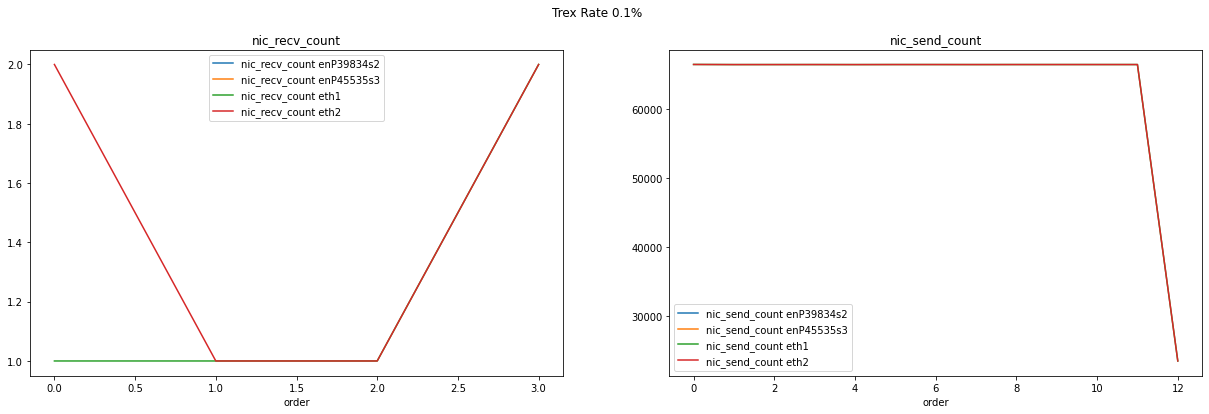

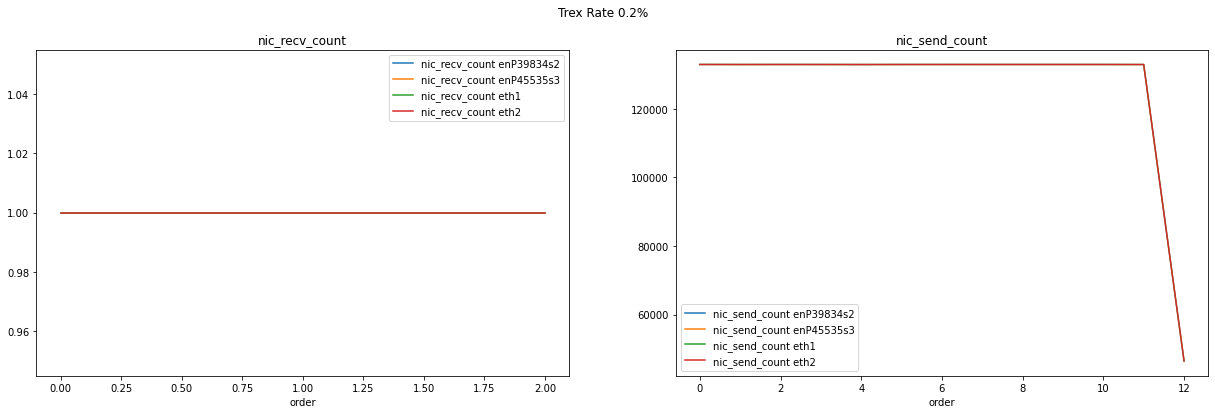

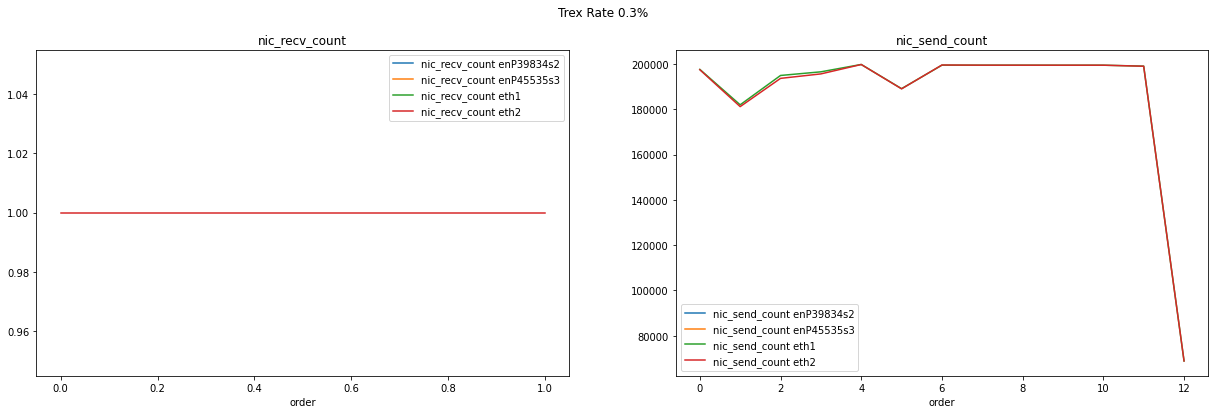

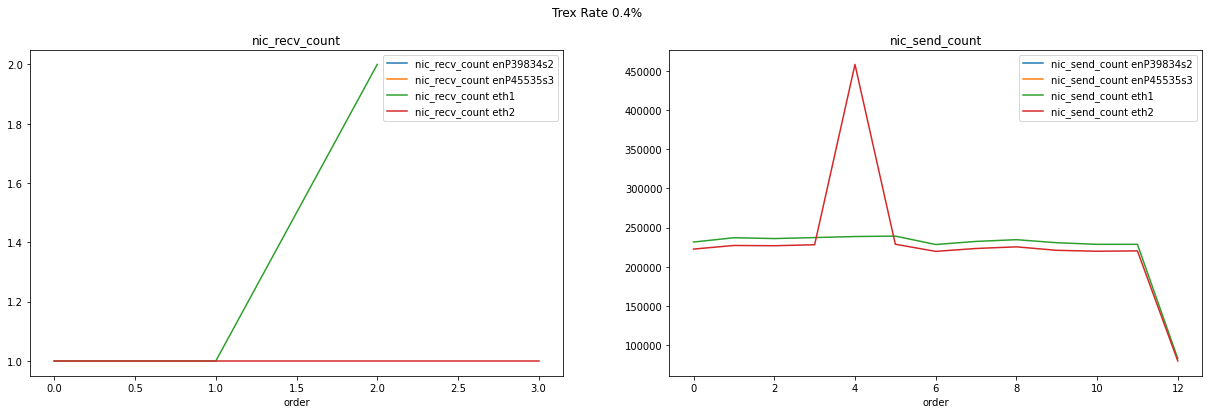

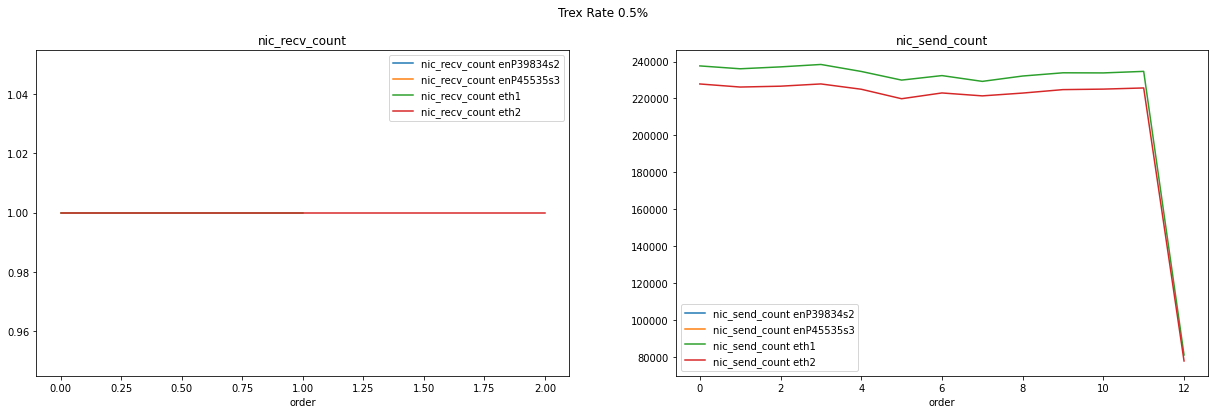

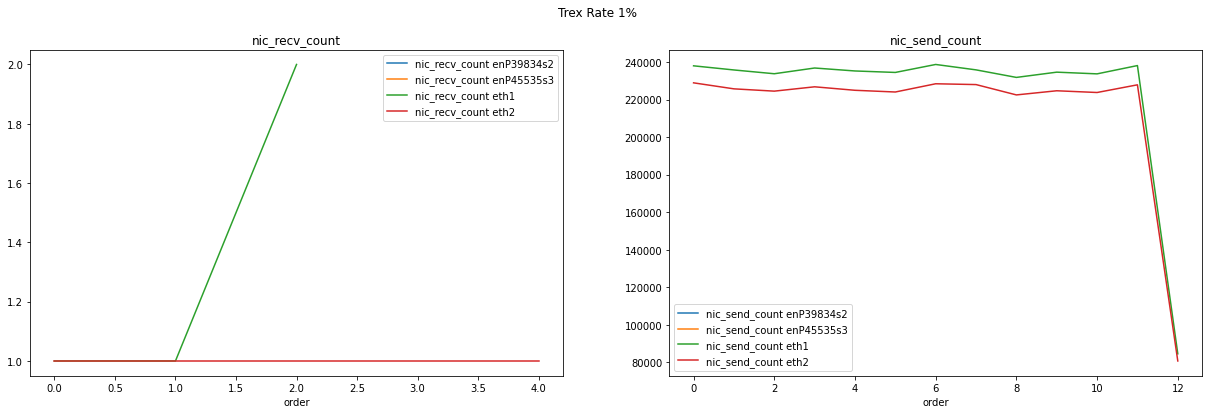

22/02/09 19:57:16 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1089970 ms exceeds timeout 120000 ms
22/02/09 19:57:17 WARN SparkContext: Killing executors is not supported by current scheduler.


In [18]:
plot_netcount_results('../ansible/.results/stl_dns_streams-rate_0.1-netcount.bt', 'Trex Rate 0.1%')
plot_netcount_results('../ansible/.results/stl_dns_streams-rate_0.2-netcount.bt', 'Trex Rate 0.2%')
plot_netcount_results('../ansible/.results/stl_dns_streams-rate_0.3-netcount.bt', 'Trex Rate 0.3%')
plot_netcount_results('../ansible/.results/stl_dns_streams-rate_0.4-netcount.bt', 'Trex Rate 0.4%')
plot_netcount_results('../ansible/.results/stl_dns_streams-rate_0.5-netcount.bt', 'Trex Rate 0.5%')
plot_netcount_results('../ansible/.results/stl_dns_streams-rate_1-netcount.bt', 'Trex Rate 1%')

In [5]:
def plot_netsize_results(file, title):
    bpftrace_netsize_pattern = r'\[(.+)\)\D*(\d+)'
    bpftrace_netsize_hdr_pattern = r'@(\w+)\[(.+)\]'
    stl_dns_streams_netsize_file = glob.glob(file)

    # Create df for histogram stats, each historgram from bpftrace is seperated by \n\n
    df2 = spark.read.text(stl_dns_streams_netsize_file, lineSep="\n\n")

    # The label of the historgram and values are seperated by :
    df3 = df2.select('value').withColumn('Type', split(df2['value'], ':').getItem(0)).withColumn('Result', split(df2['value'], ':').getItem(1))

    # The histogram bars are seperated by \n
    df4 = df3.withColumn('Result',explode(split('Result','\n')))

    # Extract the actions, device names, x-axis range and the value (number)
    bpftrace_sz_df = df4.select(
                                col('Type'),
                                regexp_extract('Type', bpftrace_netsize_hdr_pattern, 1).alias('action'),
                                regexp_extract('Type', bpftrace_netsize_hdr_pattern, 2).alias('device'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 1).alias('range'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 2).cast('integer').alias('number'),                               
    ).dropna()

    distinct_range_df = bpftrace_sz_df.select("range").distinct()
    distinct_device_action_df = bpftrace_sz_df.select("device", "action").distinct()
    unique_comb_df = distinct_range_df.crossJoin(distinct_device_action_df)

    netsize_sum_df = bpftrace_sz_df.groupBy("action", "device", "range").agg(sum('number').alias('sum_number'))


    joined_df = unique_comb_df.join(netsize_sum_df,["action", "device", "range"],"full").withColumn('number',  when(col("sum_number") > 0, col("sum_number")).otherwise(0)).drop(col('sum_number'))

    uniq_names = ['nic_send_bytes', 'nic_recv_bytes', 'send_bytes', 'recv_bytes']
    tables = [joined_df.where(joined_df.action == x) for x in uniq_names]
    uniq_devices = ['enP39834s2', 'enP45535s3', 'eth1', 'eth2']

    fig, axs = plt.subplots(1, 4, figsize=(21,6))
    fig.suptitle(title)
    for ti, table in enumerate(tables):
        # create order column corresponding to range
        table = table.withColumn('order', regexp_replace('range', 'K', '000'))
        table = table.withColumn('order', split(table['order'], ',').getItem(0).cast('int'))
        list_tables = [table.where(table.device == x).orderBy('order').withColumn('mag', col('range') ) for x in uniq_devices]
        for i, t in enumerate(list_tables):
            df = t.toPandas()
            axs[ti] = df.plot(ax=axs[ti], kind='line', x='range', y='number', label="{} {}".format(uniq_names[ti], uniq_devices[i])) #
            # axs[i].set_ylim([0, 4e8])
        axs[ti].set_title(uniq_names[ti])

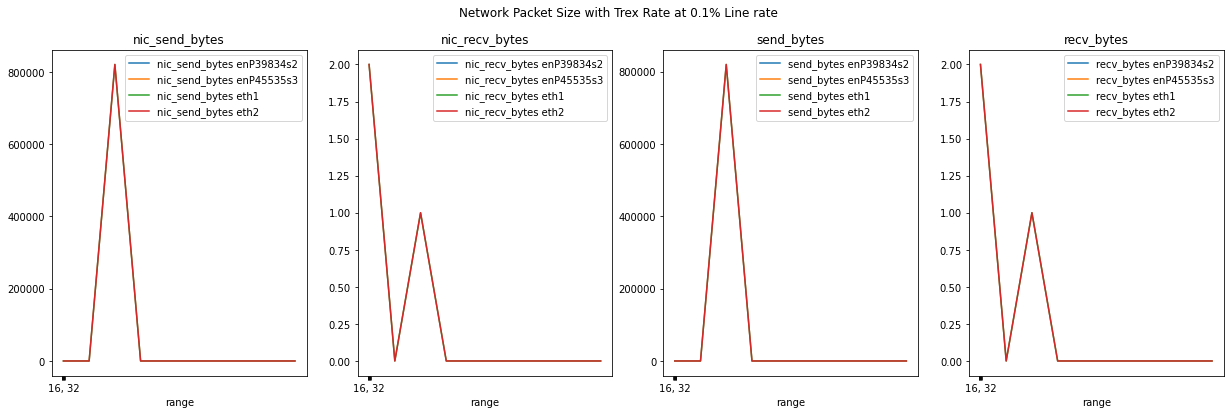

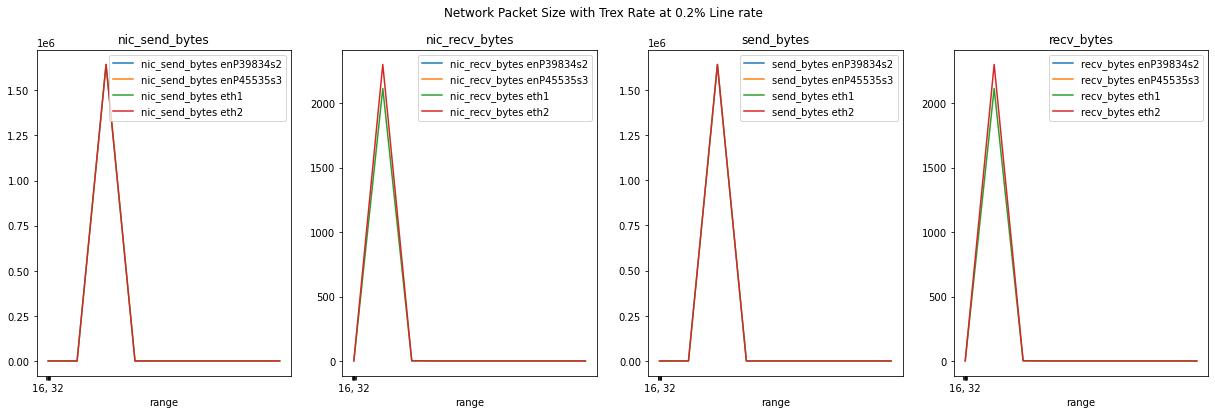

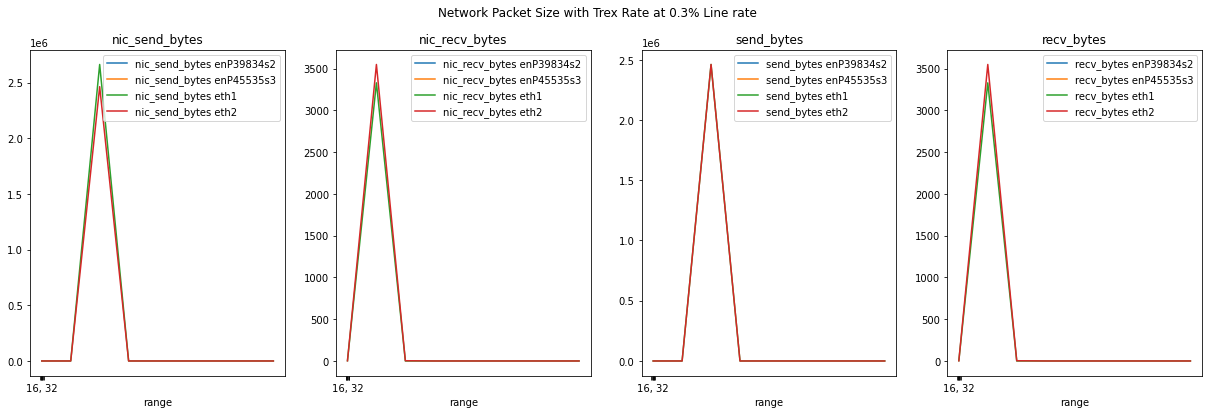

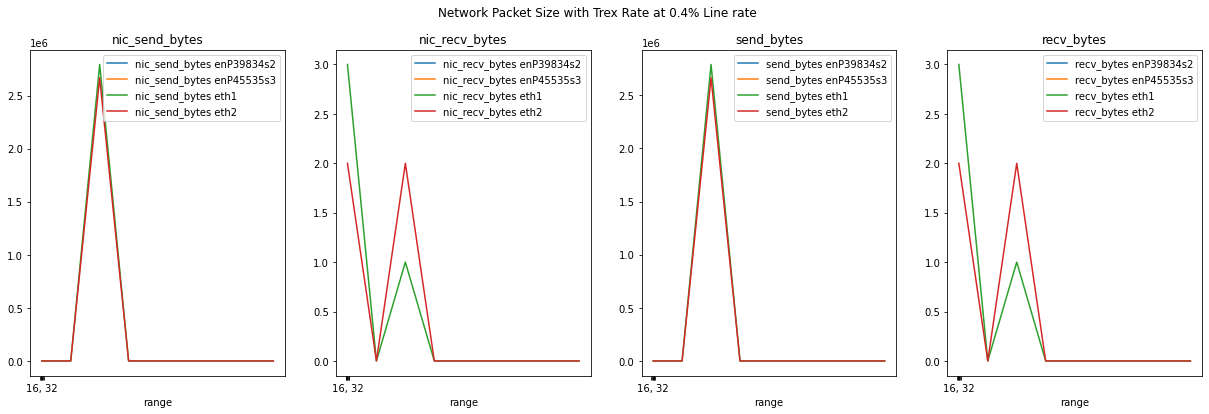

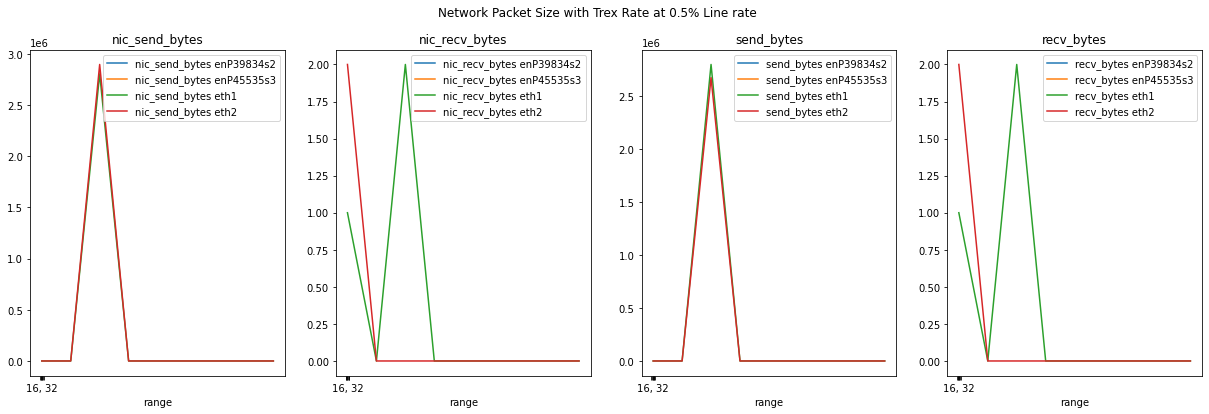

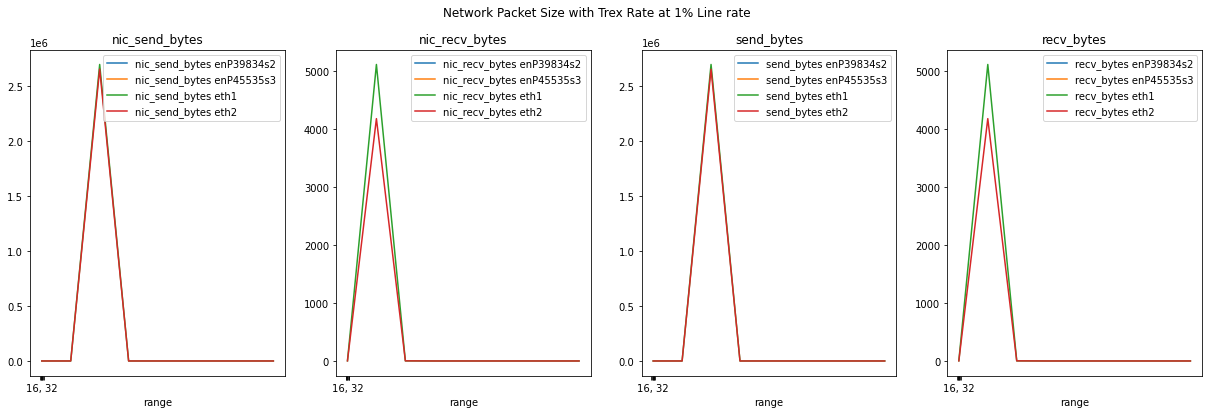

In [6]:
plot_netsize_results('../ansible/.results/stl_dns_streams-rate_0.1-netsize.bt', 'Network Packet Size with Trex Rate at 0.1% Line rate')
plot_netsize_results('../ansible/.results/stl_dns_streams-rate_0.2-netsize.bt', 'Network Packet Size with Trex Rate at 0.2% Line rate')
plot_netsize_results('../ansible/.results/stl_dns_streams-rate_0.3-netsize.bt', 'Network Packet Size with Trex Rate at 0.3% Line rate')
plot_netsize_results('../ansible/.results/stl_dns_streams-rate_0.4-netsize.bt', 'Network Packet Size with Trex Rate at 0.4% Line rate')
plot_netsize_results('../ansible/.results/stl_dns_streams-rate_0.5-netsize.bt', 'Network Packet Size with Trex Rate at 0.5% Line rate')
plot_netsize_results('../ansible/.results/stl_dns_streams-rate_1-netsize.bt', 'Network Packet Size with Trex Rate at 1% Line rate')

In [7]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_trex_results(file, title):
    stl_dns_streams_trex_file = glob.glob(file)
    stl_dns_streams_trex_df = spark.read.json(stl_dns_streams_trex_file)

    trex_df = stl_dns_streams_trex_df.select('stats.0', 'stats.1', 'stats.global')

    formated_0_df = trex_df.select(explode(trex_df['0']).alias('port_0')).withColumn('port', lit('0'))
    formated_1_df = trex_df.select(explode(trex_df['1']).alias('port_1')).withColumn('port', lit('1'))

    trex_port_0 = formated_0_df.select('port', 'port_0.ibytes', 'port_0.obytes', 'port_0.ipackets', 'port_0.opackets', 'port_0.tx_util').withColumn("id", monotonically_increasing_id())

    trex_port_1 = formated_1_df.select('port', 'port_1.ibytes', 'port_1.obytes', 'port_1.ipackets', 'port_1.opackets', 'port_1.tx_util').withColumn("id", monotonically_increasing_id())

    ports = ['0', '1']
    uniq_plots = ['ibytes', 'obytes', 'ipackets', 'opackets', 'tx_util']


    figsize = (15, 11)
    cols = 3
    rows = 3
    axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows, cols)
    axs = trim_axs(axs, 5) # 5 is the actual number of plots/datasets
    yrange = [[0, 4e9], [0, 4e9], [0, 5e7], [0, 5e7], [0, 100]]

    tables = [trex_port_0, trex_port_1]
    for ti, table in enumerate(tables):
        for i, p in enumerate(uniq_plots):
            df = table.toPandas()
            axs[i] = df.plot(ax=axs[i], kind='line', x='id', y=p, label="Port {}".format(ports[ti])) #
            axs[i].set_title(uniq_plots[i])
            # axs[i].set_
            axs[i].set_ylim(yrange[i])
    
    # for ti, table in enumerate(tables):
    #     for i, p in enumerate(uniq_plots):
    #         df = table.toPandas()
    #         axs[i] = df.plot(ax=axs[i], kind='line', x='id', y=p, label="Port {}".format(ports[ti])) #
    #         axs[i].set_title(uniq_plots[i])


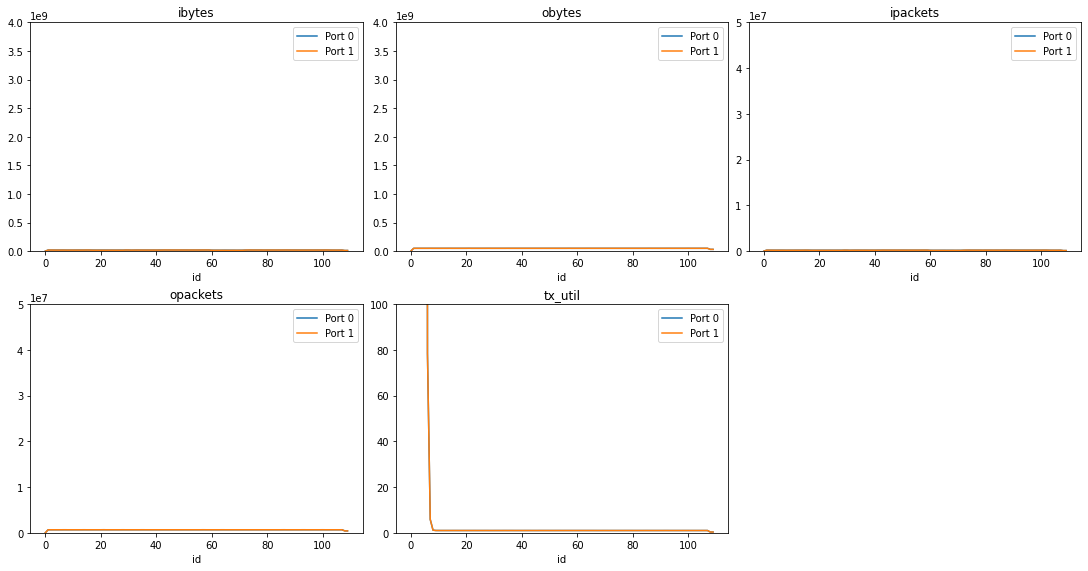

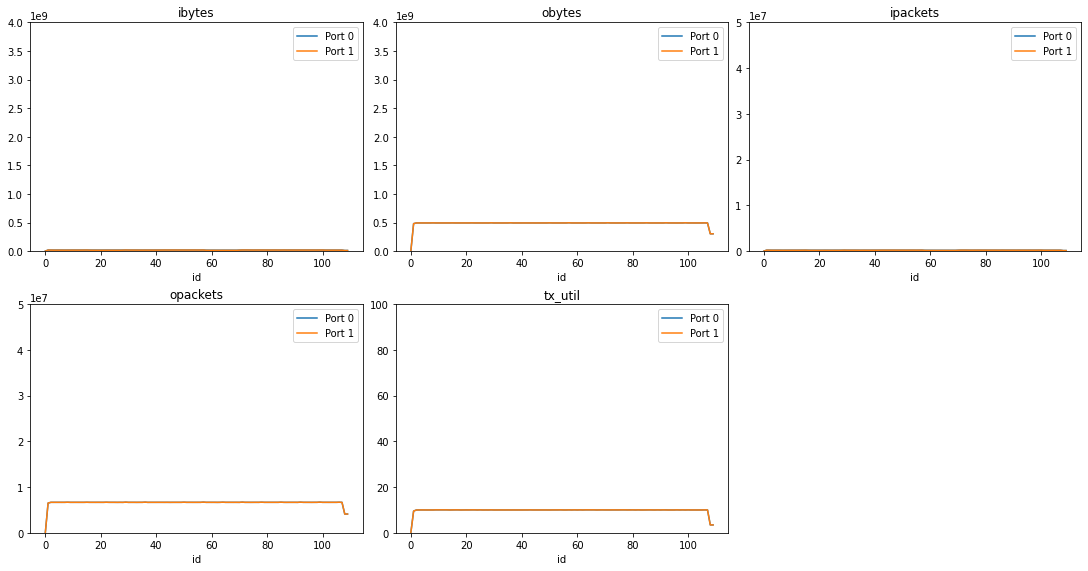

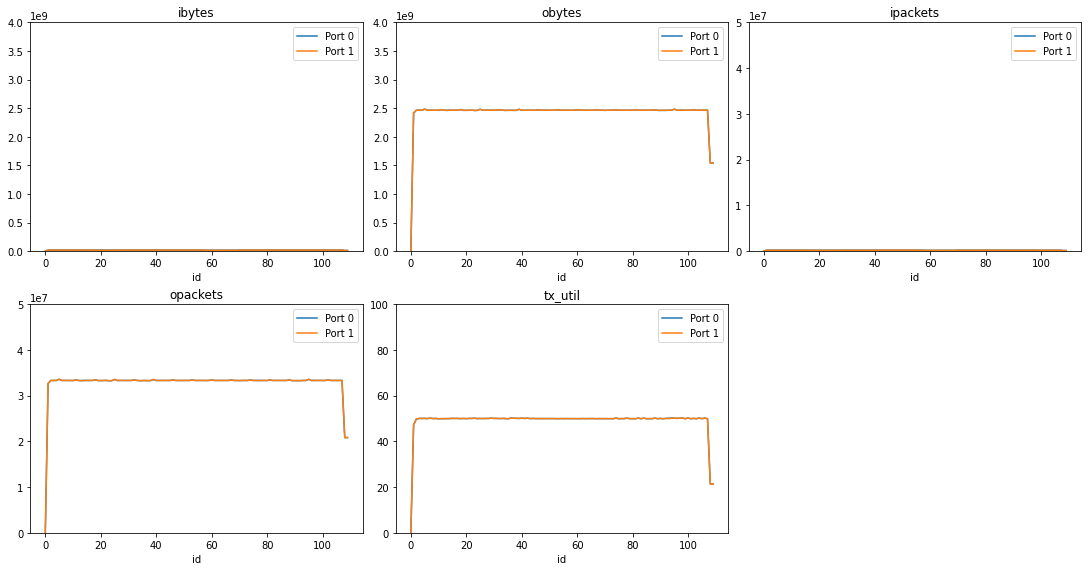

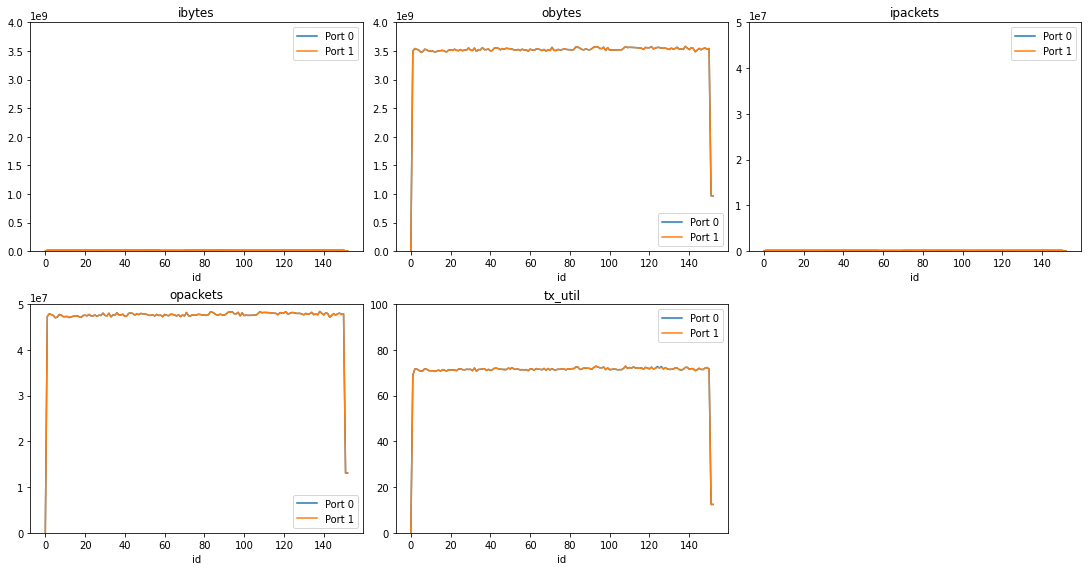

In [8]:
plot_trex_results('../ansible/.results/stl_dns_streams-rate_1-trex.json', 'Trex Rate at 1% Line rate')
plot_trex_results('../ansible/.results/stl_dns_streams-rate_10-trex.json', 'Trex Rate at 10% Line rate')
plot_trex_results('../ansible/.results/stl_dns_streams-rate_50-trex.json', 'Trex Rate at 50% Line rate')
plot_trex_results('../ansible/.results/stl_dns_streams-rate_100-trex.json', 'Trex Rate at 100% Line rate')

In [9]:
def plot_nettxlat_results(file, title):
    bpftrace_netsize_pattern = r'\[(.+)\)\D*(\d+)'
    bpftrace_netsize_hdr_pattern = r'@(\w+)\[(.+)\]'
    stl_dns_streams_netsize_file = glob.glob(file)

    # Create df for histogram stats, each historgram from bpftrace is seperated by \n\n
    df2 = spark.read.text(stl_dns_streams_netsize_file, lineSep="\n\n")

    # The label of the historgram and values are seperated by :
    df3 = df2.select('value').withColumn('Type', split(df2['value'], ':').getItem(0)).withColumn('Result', split(df2['value'], ':').getItem(1))

    # The histogram bars are seperated by \n
    df4 = df3.withColumn('Result',explode(split('Result','\n')))

    # Extract the actions, device names, x-axis range and the value (number)
    bpftrace_sz_df = df4.select(
                                col('Type'),
                                regexp_extract('Type', bpftrace_netsize_hdr_pattern, 1).alias('action'),
                                regexp_extract('Type', bpftrace_netsize_hdr_pattern, 2).alias('device'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 1).alias('range'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 2).cast('integer').alias('number'),                               
    ).dropna()

    distinct_range_df = bpftrace_sz_df.select("range").distinct()
    distinct_device_df = bpftrace_sz_df.select("device").distinct()
    unique_comb_df = distinct_range_df.crossJoin(distinct_device_df)
    
    nettxlat_sum_df = bpftrace_sz_df.groupBy("device", "range").agg(sum('number').alias('sum_number'))

    joined_df = unique_comb_df.join(nettxlat_sum_df,["device", "range"],"full").withColumn('number',  when(col("sum_number") > 0, col("sum_number")).otherwise(0)).drop(col('sum_number')).select('*').where(col('device') != "")
    
    uniq_devices = ['enP39834s2', 'enP45535s3']

    fig, ax = plt.subplots()
    
    fig.suptitle(title)
    # for ti, table in enumerate(tables):
        # create order column corresponding to range
    table = joined_df.withColumn('order', regexp_replace('range', 'K', '000'))
    table = table.withColumn('order', split(table['order'], ',').getItem(0).cast('int'))
    list_tables = [table.where(table.device == x).orderBy('order').withColumn('mag', col('range') ) for x in uniq_devices]
    for i, t in enumerate(list_tables):
        df = t.toPandas()
        ax = df.plot(ax=ax, kind='line', x='range', y='number', label="nettxlat {}".format(uniq_devices[i])) #

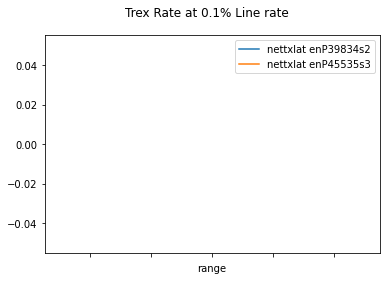

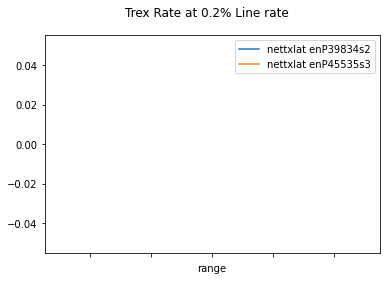

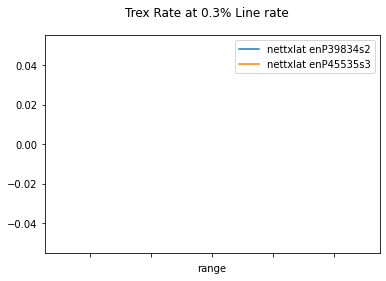

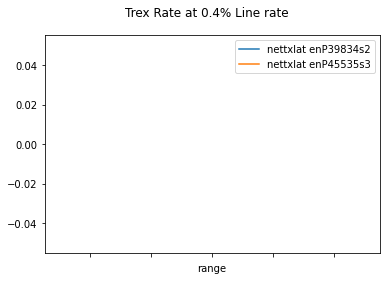

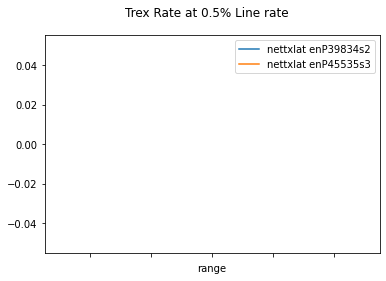

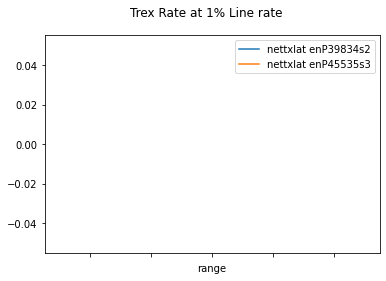

In [15]:
plot_nettxlat_results('../ansible/.results/stl_dns_streams-rate_0.1-nettxlat-dev.bt', 'Trex Rate at 0.1% Line rate')
plot_nettxlat_results('../ansible/.results/stl_dns_streams-rate_0.2-nettxlat-dev.bt', 'Trex Rate at 0.2% Line rate')
plot_nettxlat_results('../ansible/.results/stl_dns_streams-rate_0.3-nettxlat-dev.bt', 'Trex Rate at 0.3% Line rate')
plot_nettxlat_results('../ansible/.results/stl_dns_streams-rate_0.4-nettxlat-dev.bt', 'Trex Rate at 0.4% Line rate')
plot_nettxlat_results('../ansible/.results/stl_dns_streams-rate_0.5-nettxlat-dev.bt', 'Trex Rate at 0.5% Line rate')
plot_nettxlat_results('../ansible/.results/stl_dns_streams-rate_1-nettxlat-dev.bt', 'Trex Rate at 1% Line rate')

In [11]:
def plot_runqlat_results(file, title):
    bpftrace_netsize_pattern = r'\[(.+)\)\D*(\d+)'
    bpftrace_netsize_hdr_pattern = r'@(\w+)'
    stl_dns_streams_netsize_file = glob.glob(file)

    # Create df for histogram stats, each historgram from bpftrace is seperated by \n\n
    df2 = spark.read.text(stl_dns_streams_netsize_file, lineSep="\n\n")

    # The label of the historgram and values are seperated by :
    df3 = df2.select('value').withColumn('Type', split(df2['value'], ':').getItem(0)).withColumn('Result', split(df2['value'], ':').getItem(1))

    # The histogram bars are seperated by \n
    df4 = df3.withColumn('Result',explode(split('Result','\n')))

    # Extract the actions, device names, x-axis range and the value (number)
    bpftrace_sz_df = df4.select(
                                col('Type'),
                                regexp_extract('Type', bpftrace_netsize_hdr_pattern, 1).alias('action'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 1).alias('range'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 2).cast('integer').alias('number'),                               
    ).dropna()

    distinct_range_df = bpftrace_sz_df.select("range").distinct()
    distinct_device_df = bpftrace_sz_df.select("action").distinct()
    unique_comb_df = distinct_range_df.crossJoin(distinct_device_df)
    
    nettxlat_sum_df = bpftrace_sz_df.groupBy("action", "range").agg(sum('number').alias('sum_number'))

    joined_df = unique_comb_df.join(nettxlat_sum_df,["action", "range"],"full").withColumn('number',  when(col("sum_number") > 0, col("sum_number")).otherwise(0)).drop(col('sum_number')).select('*').where(col('action') != "")
    
    tables = [joined_df]

    fig, ax = plt.subplots()
    
    fig.suptitle(title)
        # create order column corresponding to range
    table = joined_df.withColumn('order', regexp_replace('range', 'K', '000'))
    table = table.withColumn('order', split(table['order'], ',').getItem(0).cast('int'))
    table = table.orderBy('order')
    
    df = table.toPandas()
    ax = df.plot(ax=ax, kind='line', x='range', y='number', label="runqlat") #

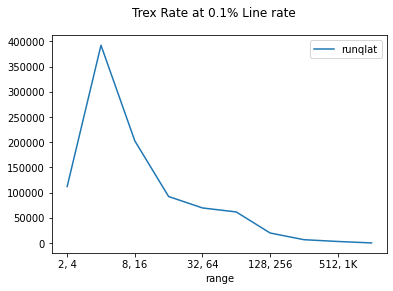

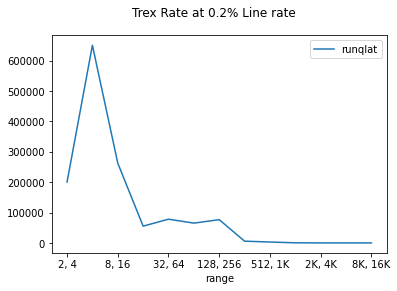

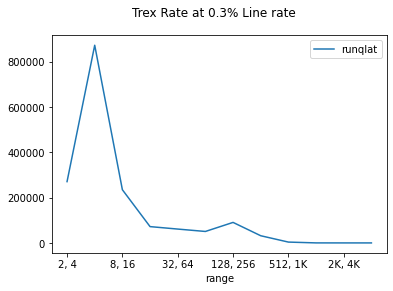

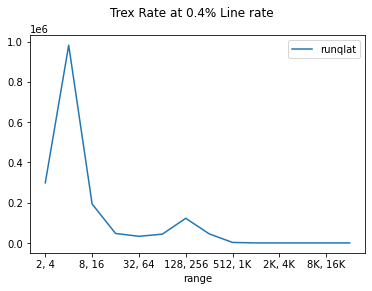

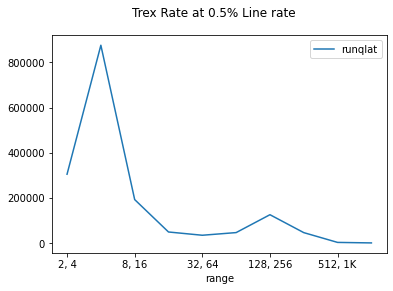

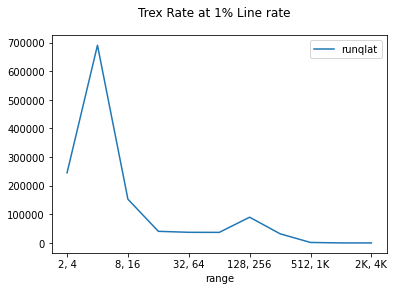

In [16]:
plot_runqlat_results('../ansible/.results/stl_dns_streams-rate_0.1-runqlat.bt', 'Trex Rate at 0.1% Line rate')
plot_runqlat_results('../ansible/.results/stl_dns_streams-rate_0.2-runqlat.bt', 'Trex Rate at 0.2% Line rate')
plot_runqlat_results('../ansible/.results/stl_dns_streams-rate_0.3-runqlat.bt', 'Trex Rate at 0.3% Line rate')
plot_runqlat_results('../ansible/.results/stl_dns_streams-rate_0.4-runqlat.bt', 'Trex Rate at 0.4% Line rate')
plot_runqlat_results('../ansible/.results/stl_dns_streams-rate_0.5-runqlat.bt', 'Trex Rate at 0.5% Line rate')
plot_runqlat_results('../ansible/.results/stl_dns_streams-rate_1-runqlat.bt', 'Trex Rate at 1% Line rate')

In [13]:
def plot_skblife_results(file, title):
    bpftrace_netsize_pattern = r'\[(.+)\)\D*(\d+)'
    bpftrace_netsize_hdr_pattern = r'@(\w+)'
    stl_dns_streams_netsize_file = glob.glob(file)

    # Create df for histogram stats, each historgram from bpftrace is seperated by \n\n
    df2 = spark.read.text(stl_dns_streams_netsize_file, lineSep="\n\n")

    # The label of the historgram and values are seperated by :
    df3 = df2.select('value').withColumn('Type', split(df2['value'], ':').getItem(0)).withColumn('Result', split(df2['value'], ':').getItem(1))

    # The histogram bars are seperated by \n
    df4 = df3.withColumn('Result',explode(split('Result','\n')))

    # Extract the actions, device names, x-axis range and the value (number)
    bpftrace_sz_df = df4.select(
                                col('Type'),
                                regexp_extract('Type', bpftrace_netsize_hdr_pattern, 1).alias('action'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 1).alias('range'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 2).cast('integer').alias('number'),                               
    ).dropna()

    distinct_range_df = bpftrace_sz_df.select("range").distinct()
    distinct_device_df = bpftrace_sz_df.select("action").distinct()
    unique_comb_df = distinct_range_df.crossJoin(distinct_device_df)
    
    nettxlat_sum_df = bpftrace_sz_df.groupBy("action", "range").agg(sum('number').alias('sum_number'))

    joined_df = unique_comb_df.join(nettxlat_sum_df,["action", "range"],"full").withColumn('number',  when(col("sum_number") > 0, col("sum_number")).otherwise(0)).drop(col('sum_number')).select('*').where(col('action') != "")


    fig, ax = plt.subplots()
    
    fig.suptitle(title)
    
    table = joined_df.withColumn('order', lit(0))
    table = table.withColumn('order',  when(split(table['range'], ',').getItem(0).contains('K'), regexp_replace('range', 'K', '000')).otherwise(col('order')))
    table = table.withColumn('order',  when(split(table['range'], ',').getItem(0).contains('M'), regexp_replace('range', 'M', '000000')).otherwise(col('order')))
    table = table.withColumn('order',  when(split(table['range'], ',').getItem(0).contains('G'), regexp_replace('range', 'G', '000000000')).otherwise(col('order')))
    table = table.withColumn('order', split(table['order'], ',').getItem(0).cast('int'))
    table = table.orderBy('order')

    df = table.toPandas()
    ax = df.plot(ax=ax, kind='line', x='range', y='number', label="skb_residency_nsecs")

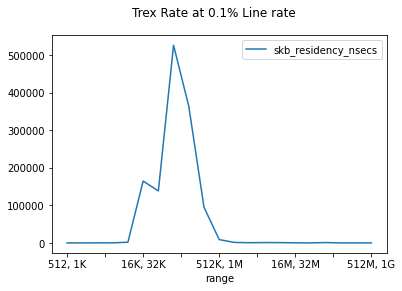

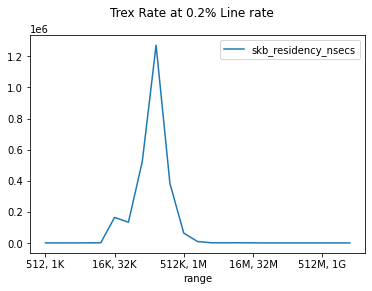

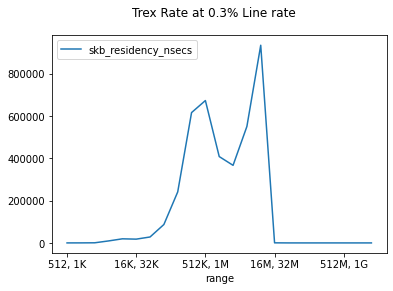

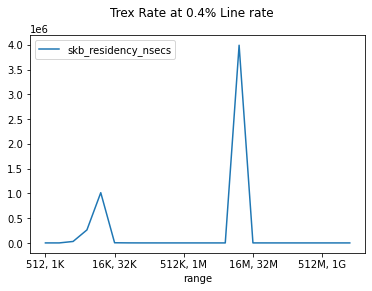

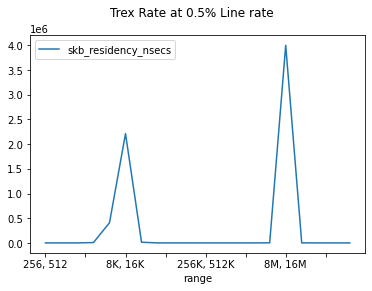

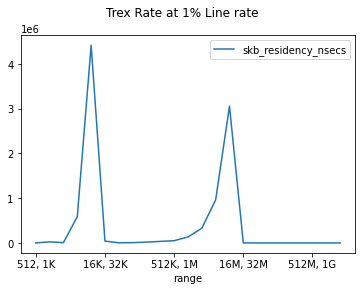

In [17]:
plot_skblife_results('../ansible/.results/stl_dns_streams-rate_0.1-skblife.bt', 'Trex Rate at 0.1% Line rate')
plot_skblife_results('../ansible/.results/stl_dns_streams-rate_0.2-skblife.bt', 'Trex Rate at 0.2% Line rate')
plot_skblife_results('../ansible/.results/stl_dns_streams-rate_0.3-skblife.bt', 'Trex Rate at 0.3% Line rate')
plot_skblife_results('../ansible/.results/stl_dns_streams-rate_0.4-skblife.bt', 'Trex Rate at 0.4% Line rate')
plot_skblife_results('../ansible/.results/stl_dns_streams-rate_0.5-skblife.bt', 'Trex Rate at 0.5% Line rate')
plot_skblife_results('../ansible/.results/stl_dns_streams-rate_1-skblife.bt', 'Trex Rate at 1% Line rate')